In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit, fsolve
from collections import defaultdict
import pickle

In [62]:
def nested_dict():
    return defaultdict(nested_dict)

In [260]:
SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the figure title

plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = True

In [224]:
with open('data.pickle', 'rb') as f:
    data_map = pickle.load(f)

In [240]:
a = data_map[10][100][40]
a['t'] = a['t'] - a['t'].iloc[76]
a['t'] = a['t'][a['t'] > 0]

In [244]:
a['theta'] = savgol_filter(a['theta'], 10, 3)

In [242]:
a['theta'][a['theta'] < 0] = a['theta'][a['theta'] < 0] * 0.9

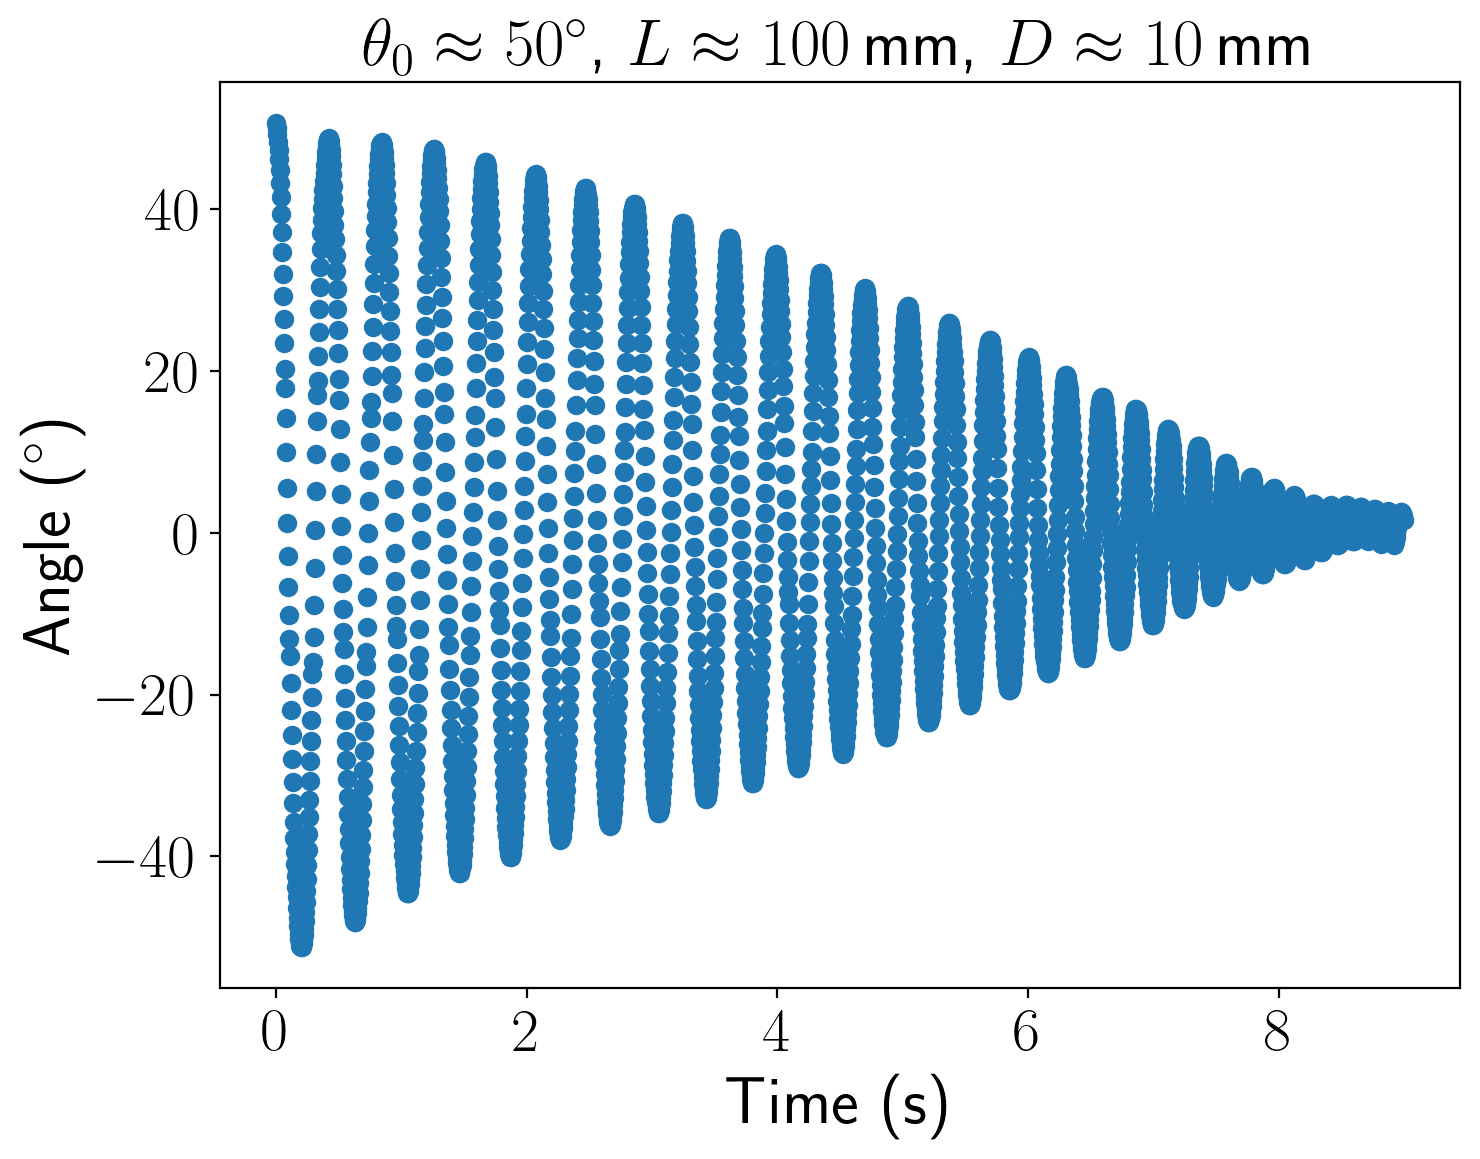

In [264]:
plt.plot(a['t'][a['t'] < 9], a['theta'][a['t'] < 9] * 180 / np.pi, linestyle='None', marker='o')
plt.xlabel('Time (s)')
plt.ylabel('Angle ($^\circ$)')
plt.title(r'$\theta_0 \approx 50^\circ$, $L \approx 100$\,mm, $D \approx 10$\,mm')

plt.savefig('oscilllations.png')

In [230]:
a['omega'] = savgol_filter(np.gradient(a['theta']) / (1/240), 30, 10)

/tmp/ipykernel_280476/119088187.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['omega'] = savgol_filter(np.gradient(a['theta']) / (1/240), 30, 10)


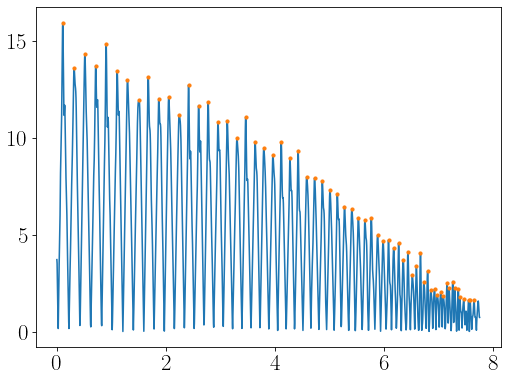

In [233]:
plt.plot(a['t'][a['t'] < 7.75], np.abs(a['omega'][a['t'] < 7.75]))
peaks, _ = find_peaks(np.abs(a['omega'][a['t'] < 7.75]), prominence=1)
plt.plot(a['t'][a['t'] < 7.75].iloc[peaks], np.abs(a['omega'][a['t'] < 7.75].iloc[peaks]), linestyle='None', marker='.')

In [234]:
peaks_amplitudes = np.abs(a['omega'][a['t'] > 0].iloc[peaks].to_numpy())

lin = lambda x, a, b: b * np.e ** (a * x)

In [235]:
popt, pcov = curve_fit(lin, np.arange(0, len(peaks_amplitudes)-10), peaks_amplitudes[10:], bounds=((-np.inf, -np.inf), (0, np.inf)))

In [236]:
popt

array([-0.03920004, 13.58554616])

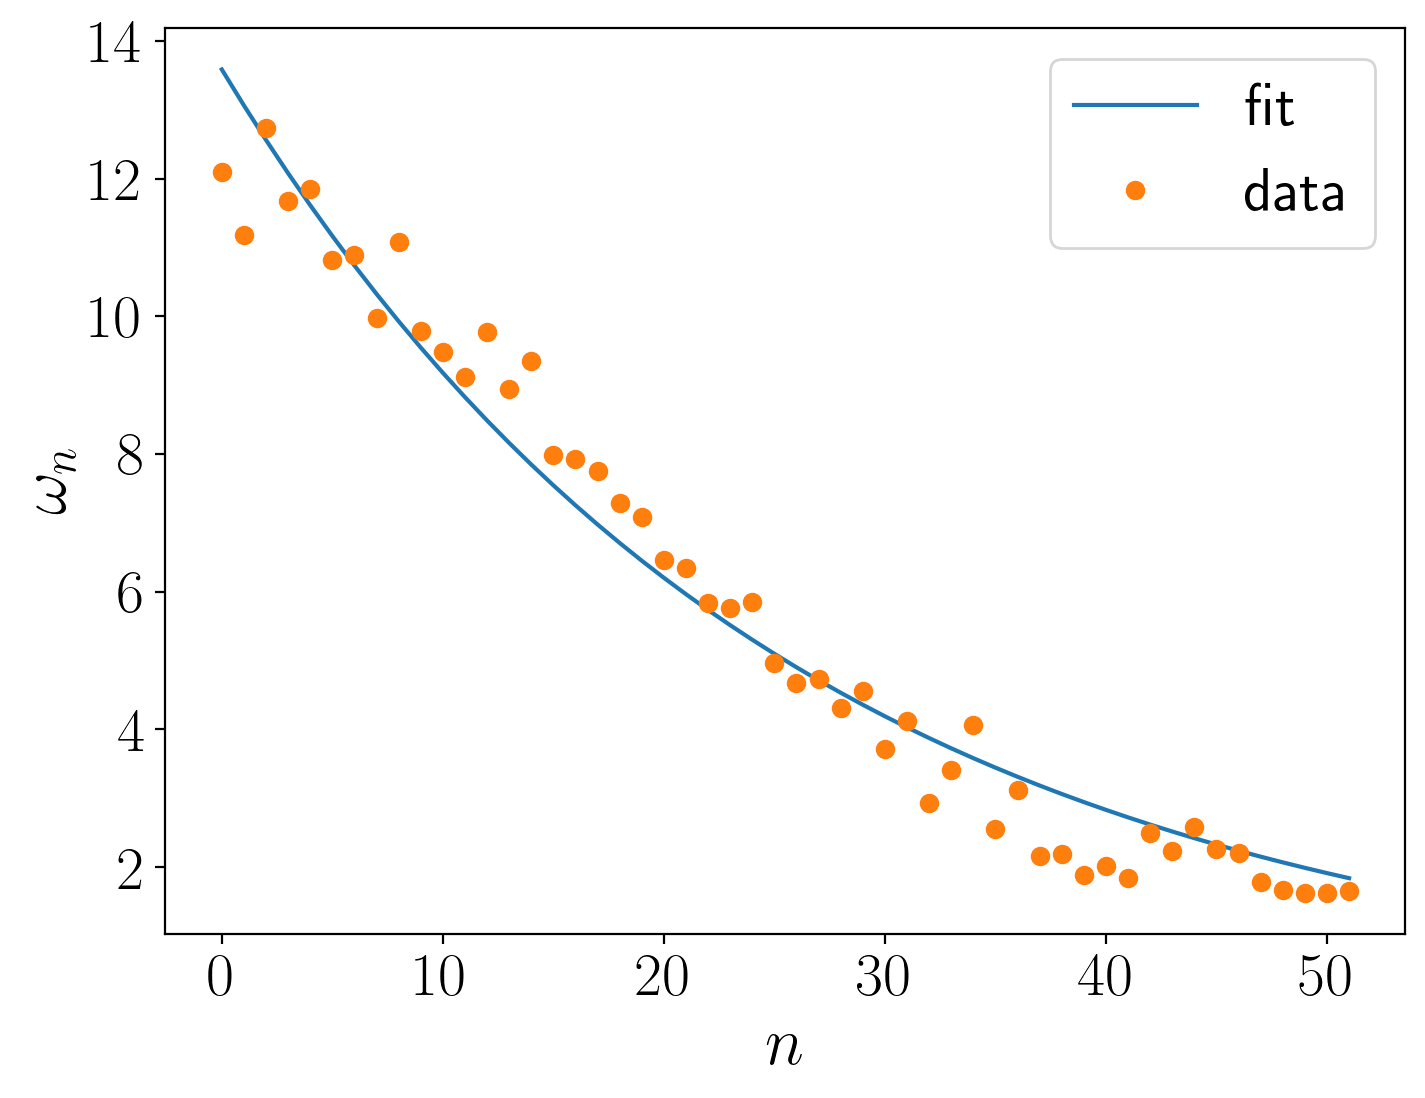

In [263]:
plt.plot(np.arange(0, len(peaks_amplitudes) - 10), lin(np.arange(0, len(peaks_amplitudes) - 10), *popt), label='fit')
plt.plot(np.arange(0, len(peaks_amplitudes) - 10), peaks_amplitudes[10:], linestyle='None', marker='o', label='data')

plt.legend()

plt.xlabel("$n$")
plt.ylabel("$\omega_n$")

plt.savefig('restitution.png')

In [191]:
coeffs_of_restit = peaks_amplitudes[:-1] / peaks_amplitudes[1:]

In [195]:
np.average(coeffs_of_restit[coeffs_of_restit < 1])

0.94022024782127

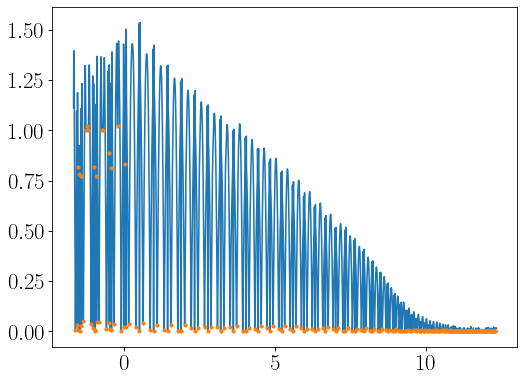

In [116]:
peaks, _ = find_peaks(-np.abs(a['theta']))
plt.plot(a['t'], np.abs(a['theta']))
plt.plot(a['t'][peaks], np.abs(a['theta'][peaks]), linestyle='None', marker='.')
periods = np.diff(a['t'][peaks])

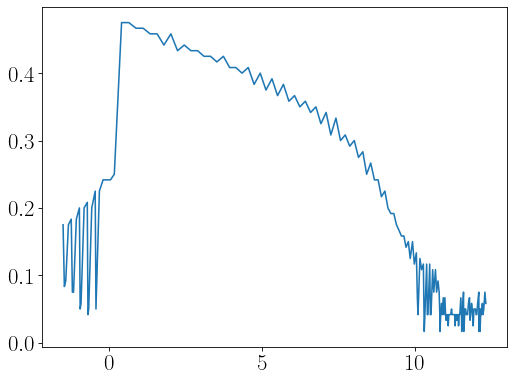

In [76]:
plt.plot(a['t'][peaks][1:], periods * 2)

In [77]:
a

,t,x,y,z,phi,theta
0,-1.668333,110.324563,-14.493040,16.779675,-0.130619,1.108482
1,-1.664162,108.072135,-13.832347,15.135386,-0.127300,1.302014
2,-1.659991,105.405532,-13.245572,28.534691,-0.125008,1.393300
3,-1.655821,102.090491,-12.394086,39.037397,-0.120812,1.402659
4,-1.651650,98.323325,-11.833492,47.879978,-0.119777,1.350409
...,...,...,...,...,...,...
3350,12.303957,1.412458,0.184151,109.990777,0.129645,0.019144
3351,12.308127,1.306932,0.267024,109.991912,0.201540,0.018710
3352,12.312297,1.548482,0.073108,109.989076,0.047178,0.017854
3353,12.316467,1.573753,0.057636,109.988727,0.036607,0.017488


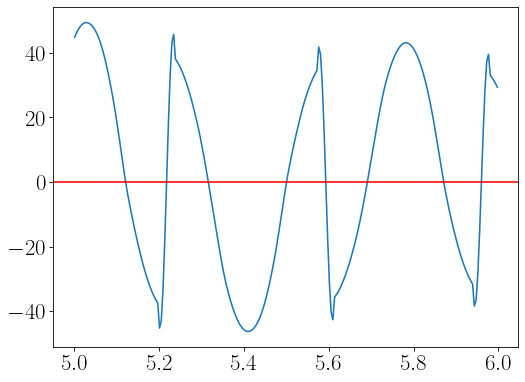

In [117]:
a = data_map[10][100][80]
plt.plot(a['t'][(a['t'] > 5) & (a['t'] < 6)], a['theta'][(a['t'] > 5) & (a['t'] < 6)] * 180 / np.pi)
plt.axhline(y = 0   , color = 'r', linestyle = '-')

peaks, _ = find_peaks(-a['theta'], prominence=0)

peaks = peaks[a['theta'][peaks] < 0.26]

# plt.plot(a['t'][peaks], a['theta'][peaks] * 180 / np.pi, marker='o', linestyle='None')
# plt.plot(a['t'], a['x'])
# plt.plot(a['t'], a['y'])

In [79]:
peaks_beginning = peaks[::2]
peaks_end = peaks[1::2]

if len(peaks_beginning) > len(peaks_end):
    peaks_beginning = peaks_beginning[:-1]

negative_parts_bounds = np.column_stack([peaks_beginning, peaks_end])

for bound in negative_parts_bounds:
    a['theta'][bound[0]:bound[1]] = 0 - a['theta'][bound[0]:bound[1]]

In [80]:
peaks[1::2]

array([  40,   64,  168,  184,  291,  402,  524,  747,  961, 1168, 1368,
       1559, 1742, 1916, 2080, 2232, 2371, 2494, 2597, 2682, 2753, 2815,
       2843, 2869, 2893, 2917, 2941, 2983, 2994, 3011, 3032, 3046, 3057,
       3068, 3081, 3094, 3108, 3113, 3126, 3138, 3149, 3163, 3179, 3199,
       3210, 3228, 3235, 3252, 3272, 3285, 3307, 3323, 3341])

In [81]:
popt

array([-0.02606393,  1.59104975])